In [7]:
# Import necessary libraries
import os, csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [8]:
# Load the dataset
def load_data(filename):
    if not os.path.exists(filename):
        print(f"{filename} does not exist")
        return None
    
    return pd.read_csv(filename)
filename = "./Lumos5G-v1.0.csv"
data = load_data(filename=filename)

In [9]:
# Show basic information
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68118 entries, 0 to 68117
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   run_num               68118 non-null  int64  
 1   seq_num               68118 non-null  float64
 2   abstractSignalStr     68118 non-null  int64  
 3   latitude              68118 non-null  float64
 4   longitude             68118 non-null  float64
 5   movingSpeed           68118 non-null  float64
 6   compassDirection      68118 non-null  int64  
 7   nrStatus              68118 non-null  object 
 8   lte_rssi              65137 non-null  float64
 9   lte_rsrp              68118 non-null  int64  
 10  lte_rsrq              65137 non-null  float64
 11  lte_rssnr             65137 non-null  float64
 12  nr_ssRsrp             51990 non-null  float64
 13  nr_ssRsrq             51990 non-null  float64
 14  nr_ssSinr             51990 non-null  float64
 15  Throughput         

In [11]:
# Drop rows with any missing values for clustering purposes
data_clean = data.dropna()

In [12]:
# Select relevant numeric features for KMeans
features = [
    'abstractSignalStr', 'movingSpeed', 'compassDirection',
    'lte_rssi', 'lte_rsrp', 'lte_rsrq', 'lte_rssnr',
    'nr_ssRsrp', 'nr_ssRsrq', 'nr_ssSinr', 'Throughput'
]

X = data_clean[features]

In [13]:
# Scale the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [14]:
# Determine the optimal number of clusters using the Elbow method
inertia = []
k_range = range(1, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_scaled)
    inertia.append(km.inertia_)

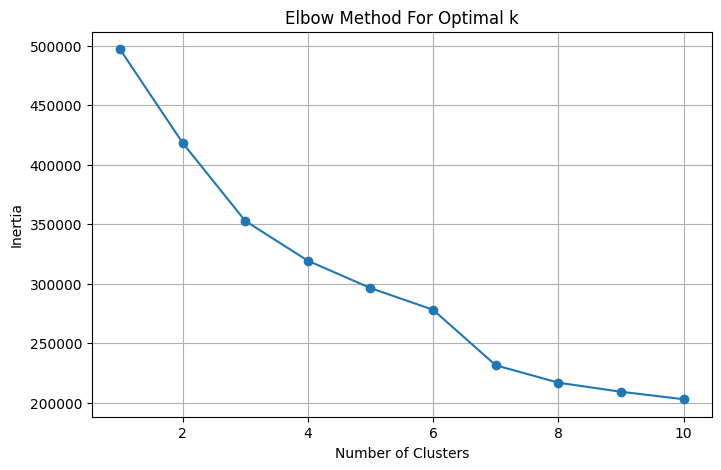

In [18]:
# Plot the Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.grid(True)
plt.show()

In [15]:
# Apply KMeans with chosen number of clusters (e.g., k=3)
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
data_clean['Cluster'] = kmeans.fit_predict(X_scaled)

# Reduce to 2D using PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

C:\Users\nabit\AppData\Local\Temp\ipykernel_5424\218889150.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['Cluster'] = kmeans.fit_predict(X_scaled)


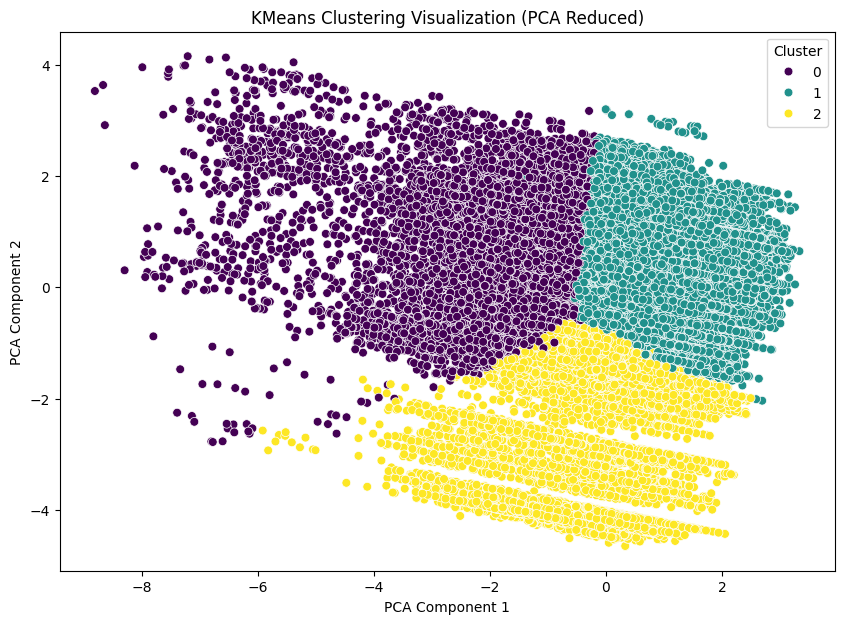

In [22]:
# Plot Clusters
plt.figure(figsize=(10, 7))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=data_clean['Cluster'], palette='viridis', s=40)
plt.title('KMeans Clustering Visualization (PCA Reduced)')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

In [23]:
# Analyze cluster means
cluster_centers = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), columns=features)
print("Cluster Centers:")
print(cluster_centers)

Cluster Centers:
   abstractSignalStr  movingSpeed  compassDirection   lte_rssi    lte_rsrp  \
0           4.007851     2.565636        176.766507 -53.213708  -77.787862   
1           4.083279     1.379196        178.774576 -51.968797  -75.699964   
2           3.893115     1.598188        187.146536 -69.151708 -102.498007   

    lte_rsrq     lte_rssnr  nr_ssRsrp     nr_ssRsrq  nr_ssSinr  Throughput  
0 -12.449870  2.147484e+09 -98.555547  1.411199e+08   3.914658  236.842349  
1 -11.407981  2.147484e+09 -85.052293  2.326514e+05  14.791369  821.465511  
2 -16.158388  2.147484e+09 -88.093955  4.859072e+06  12.993858  661.833854  


C:\Users\nabit\AppData\Local\Temp\ipykernel_5424\3499232436.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='Cluster', y='Throughput', data=data_clean, palette='Set3')


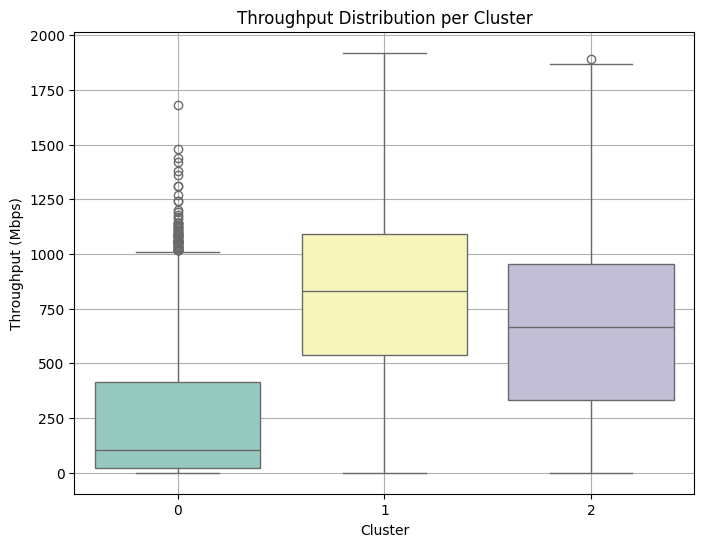

In [16]:
#Cluster-wise Throughput Distribution
plt.figure(figsize=(8, 6))
sns.boxplot(x='Cluster', y='Throughput', data=data_clean, palette='Set3')
plt.title('Throughput Distribution per Cluster')
plt.xlabel('Cluster')
plt.ylabel('Throughput (Mbps)')
plt.grid(True)
plt.show()

C:\Users\nabit\AppData\Local\Temp\ipykernel_5424\3882912944.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clean['5G_Connected'] = data_clean['nrStatus'] == 'CONNECTED'


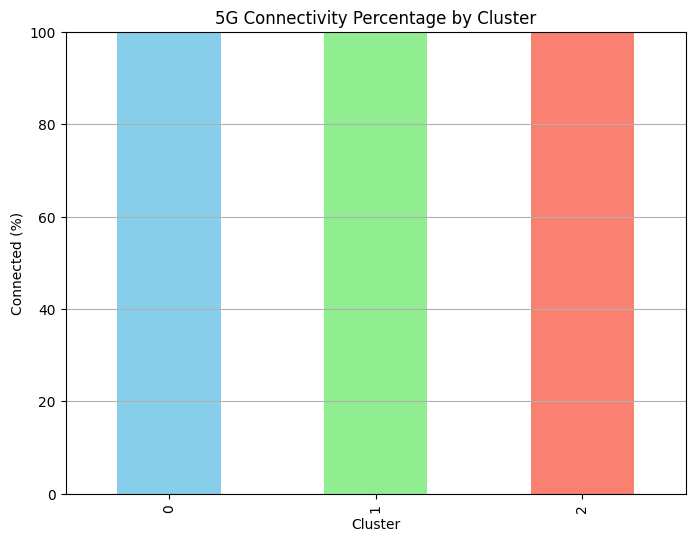

In [20]:
#5G Connectivity Rate per Cluster
data_clean['5G_Connected'] = data_clean['nrStatus'] == 'CONNECTED'
connectivity = data_clean.groupby('Cluster')['5G_Connected'].mean() * 100

plt.figure(figsize=(8, 6))
connectivity.plot(kind='bar', color=['skyblue', 'lightgreen', 'salmon'])
plt.title('5G Connectivity Percentage by Cluster')
plt.ylabel('Connected (%)')
plt.xlabel('Cluster')
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()